<a href="https://colab.research.google.com/github/millergw/cs181-s23-homeworks/blob/main/CS181_Practical_I_Alison_Ben_Gwen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Starter Code
### CS 181 Practical, Spring 2023
author: njohnson

**Please copy this notebook by clicking "File" -> "Save a Copy in Drive".**

This notebook contains starter code to:


*   **Load all of the data files** directly into your Colab runtime from the GCP bucket (so you don't need to download them to your computer!)
*   **Install libraries** inline, so you don't need to install them to your computer!




# Before you run this code:

1.   **Change your Runtime to use a GPU**: Click "Runtime" -> "Change Runtime Type", and select "GPU".
2.   **Stop Colab from disconnecting**:  To prevent Google Colab from disconnecting while you're away,  you can add an auto-click function using the Chrome console Just "Inspect", navigate to the "Console" and paste in this function:

```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("#ok").click()
}
setInterval(ClickConnect,60000)
```







In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import sklearn modules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
# TODO: add pytorch modules
import tqdm # to track progress of loops

import logging
logging.basicConfig(
            format='%(asctime)s %(levelname)-8s %(message)s',
            level=logging.INFO,
            datefmt='%Y-%m-%d %H:%M:%S')

logger = logging.getLogger()
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

## Load the data files into local memory from the GCP bucket.

In [ ]:
!gsutil cp gs://cs181_practical_data/Xtrain_amp.npy ./
!gsutil cp gs://cs181_practical_data/ytrain_amp.npy ./

!gsutil cp gs://cs181_practical_data/Xtest_amp.npy ./
!gsutil cp gs://cs181_practical_data/ytest_amp.npy ./

!gsutil cp gs://cs181_practical_data/Xtrain_mel.npy ./
!gsutil cp gs://cs181_practical_data/ytrain_mel.npy ./

!gsutil cp gs://cs181_practical_data/Xtest_mel.npy ./
!gsutil cp gs://cs181_practical_data/ytest_mel.npy ./

Copying gs://cs181_practical_data/Xtrain_amp.npy...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][934.2 MiB/934.2 MiB]                                                
Operation completed over 1 objects/934.2 MiB.                                    
Copying gs://cs181_practical_data/ytrain_amp.npy...
/ [1 files][ 43.5 KiB/ 43.5 KiB]                                                
Operation completed over 1 objects/43.5 KiB.                                     
Copying gs://cs181_practical_data/Xtest_amp.npy...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1 files][369.6 MiB/369.6 M

### Load raw amplitude data as a numpy object.

In [ ]:
# Load train data

X_amp_train = np.load("Xtrain_amp.npy")
y_amp_train = np.load("ytrain_amp.npy")

In [ ]:
X_amp_train.shape

(5553, 44100)

In [ ]:
# Load test data

X_amp_test = np.load("Xtest_amp.npy")
y_amp_test = np.load("ytest_amp.npy")

In [ ]:
X_amp_test.shape

(2197, 44100)

### Load Mel spectrogram data as a numpy object.

In [ ]:
# Load train data

X_mel_train = np.load("Xtrain_mel.npy")
y_mel_train = np.load("ytrain_mel.npy")

In [ ]:
X_mel_train.shape

(5553, 128, 87)

In [ ]:
# Flatten X_mel_train's spectrogram features
X_mel_train_flat = X_mel_train.reshape(X_mel_train.shape[0], -1)
X_mel_train_flat.shape

(5553, 11136)

In [ ]:
# Load test data

X_mel_test = np.load("Xtest_mel.npy")
y_mel_test = np.load("ytest_mel.npy")

In [ ]:
X_mel_test.shape

(2197, 128, 87)

In [ ]:
# Flatten X_mel_test's spectrogram features
X_mel_test_flat = X_mel_test.reshape(X_mel_test.shape[0], -1)
X_mel_test_flat.shape

(2197, 11136)

### Delete an object from local memory.

The "del" keyword in Python is used to dereference objects from local memory.  You can use it to save memory by getting rid of variables that you don't intend to use anymore.

For example, to delete the variable X_mel_train:

In [ ]:
# del X_mel_train

### Example package installation

You can install packages using pip by running lines of code preceded by "!".  For example, the below line of code installs the librosa package:

In [ ]:
! pip install librosa umap umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# After you've installed a package, you can import it
import librosa
from sklearn.model_selection import GridSearchCV
import umap

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


# Ben's code
- Logistic regression on raw amp. Features
- One nonlinear model – Random Forest

- Perhaps elastic net regularization, compatible with the 'saga' solver, is best?
- We may want to implement k-fold cross validation for hyperparameter tuning

Structure & clustering of dataset with UMAP:

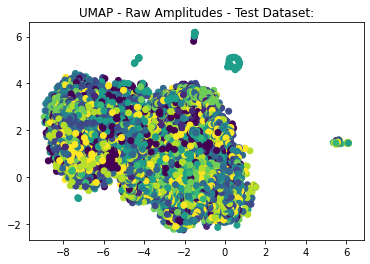

In [ ]:
# Function for plotting UMAP:

def UMAP_plotter(dataset, labels, title):
  umap_model = umap.UMAP()
  umap_amplitudes = umap_model.fit_transform(dataset)
  plt.scatter(umap_amplitudes[:,0], umap_amplitudes[:,1], c=labels)
  plt.title(title)

# UMAP for training dataset:

UMAP_plotter(X_amp_train, y_amp_train, "UMAP - Raw Amplitudes - Training Dataset:")

# UMAP for test dataset:

UMAP_plotter(X_amp_test, y_amp_test, "UMAP - Raw Amplitudes - Test Dataset:")


Logistic Regression with Elastic Net Regularization:

In [ ]:
logReg_rawAmp = LogisticRegression(solver='saga', penalty='elasticnet')

params = {'l1_ratio':[0, 0.5, 1]}

logReg_rawAmp_kfcv = GridSearchCV(estimator=logReg_rawAmp, param_grid=params)

logReg_rawAmp_kfcv.fit(X_amp_train, y_amp_train)

print("Best model parameters for LogReg with EN Regularization:")

print(logReg_rawAmp_kfcv.best_params_)

print("Assessing accuracy of fitted model on the test dataset:")

logReg_rawAmp_kfcv.score(X_amp_test, y_amp_test)

Nonlinear model - Random Forest:

# Gwen's code
- Logistic regression on Mel spectrogram features (TODO: since this is multiclass, shouldn't we do softmax?)
- One nonlinear model - probably a NN (or doing PCA dim reduction followed by a simpler model like Random Forest or logistic regression, though I'm not sure the latter would be "non-linear" even with the PCA dim reduction)


## Ideas/considerations
- might want to do min/max scaling (vs z-standardization) on the datasets. This will help preserve relative sounds without amplifying background noises (and will prevent issues where someone screaming could be classified as a gunshot just because it's loud)

In [ ]:
# checking for class imbalance in the training dataset
_, mel_n_per_class = np.unique(y_mel_train, return_counts = True)
print(f"We have this many samples per class in the Mel training: \n{mel_n_per_class}")

# TODO: since we have some class imbalance (e.g. class ID 6 only has 83 samples) we might want to do some re-sampling to generate the training dset

In [ ]:
UMAP_plotter(X_mel_train_flat, y_mel_train, "UMAP - Raw Mel - Training Dataset:")

print("Pre-process the mel data with min/max solver to each sample is between 0 and 1")
scaler = preprocessing.MinMaxScaler()
X_mel_train_flat = scaler.fit_transform(X_mel_train_flat)

In [ ]:
UMAP_plotter(X_mel_train_flat, y_mel_train, "UMAP - MinMax transformed Mel - Training Dataset:")


In [ ]:
print("Split mel training dset into train and validation sets")
X_mel_train_split, X_mel_val_split, y_mel_train_split, y_mel_val_split = model_selection.train_test_split(X_mel_train_flat, y_mel_train, test_size=0.2, random_state=42)

print(f"Mel train split shape: {X_mel_train_split.shape}")
print(f"Mel val split shape: {X_mel_val_split.shape}")

In [ ]:
mel_logistic_clf = LogisticRegression(penalty='l1', 
                                  multi_class='multinomial', solver='saga',
                                  max_iter=10000) 
mel_logistic_clf.fit(X_mel_train_split, y_mel_train_split)

# Alison's code
- One nonlinear model - KNN